# Paragon Technology and Innovation Sales Analysis

# 1 - Introduction

The objective of this project is not just to create a forecasting model, but to create one that accurately predicts Iekly sales for the next month. It's not just about making guesses, but about using historical sales data to identify patterns and trends, and making predictions based on those patterns. Beyond that, I will try to analyze how the performance of each products towards the set KPI, which I will assume based on the average of sales. By doing so, I hope I can help Paragon to plan their inventory and staffing levels more effectively, ensuring that they are always prepared for changes in demand.

To achieve this goal, I will take the following steps: 
- Gather historical sales data and analyze it to identify trends and patterns that could be useful in predicting future sales. 
- I will select an appropriate forecasting model and train it using the historical data, adjusting the parameters as necessary to optimize performance. 
- I will then evaluate the model using mean absolute error (MEA), for final consideration which model has lowest MEA score. 
- Finally, I will use the trained model to forecast Iekly sales for the next month based on the most recent sales data available. 

As a highly enthusiastic and goal-oriented Data Scientist with over 3 years of experience working as a project manager in diverse domains of expertise, I am confident in my ability to bring a unique combination of technical expertise and analytical skills to the table. My previous experiences have equipped me with the ability to utilize data to drive solutions and my commitment to continuous learning and growth has honed my strong organizational abilities, teamwork orientation, and exceptional problem-solving skills. With a data-driven approach and a determined mindset, I am eager to leverage my analytical mindset and technical knowledge to make a significant impact as a Data Analyst/Data Scientist. I am confident that I will excel in this field and tackle any challenges that arise while remaining focused on achieving my goals.

# 2 - Import Libraries

In [577]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from math import sqrt
import statsmodels.api as sm
import pickle

from sklearn.linear_model import LinearRegression
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

import warnings
warnings.filterwarnings('ignore')

# 3 - Data Loading

In [578]:
df = pd.read_csv('data.csv')

In [579]:
# get first 10 rows
df.head(10)

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119
5,2021-52,2021-12-27,2022-01-02,01fa9977e1c61ce5542c6f0c2a1b2895,2
6,2021-52,2021-12-27,2022-01-02,043e6d02d98b44c40645c8a22812fe88,44
7,2021-52,2021-12-27,2022-01-02,0512efdcc99fa4d57c42cd2cf6c73633,165
8,2021-52,2021-12-27,2022-01-02,05262da388ab82c51c48c9535bc8b121,41
9,2021-52,2021-12-27,2022-01-02,058cc2cecb91d10e901a597e67532619,383


In [580]:
# get last 10 rows
df.tail(10)

,week_number,week_start_date,week_end_date,product_item,quantity
102723,2023-14,2023-04-03,2023-04-09,fe88080dd6a4387f1035c908d3ec26a5,4131
102724,2023-14,2023-04-03,2023-04-09,fe92a95f45cfe213258cd8da682cd1a3,9
102725,2023-14,2023-04-03,2023-04-09,fed98e52dd33638523d6028c19c3a103,21872
102726,2023-14,2023-04-03,2023-04-09,fef44d74d0c1e1d0d9f1c584391eeb60,75
102727,2023-14,2023-04-03,2023-04-09,ff24eb021c575c9a1dc709c3f8d6631a,436
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920
102732,2023-14,2023-04-03,2023-04-09,fff18f7c705e729746515e2053dee64b,53


# 4 - EDA

In [581]:
# see df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   week_number      102733 non-null  object
 1   week_start_date  102733 non-null  object
 2   week_end_date    102733 non-null  object
 3   product_item     102731 non-null  object
 4   quantity         102733 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.9+ MB


since the all date related are in `object`, I'll later change it into `datetime`

In [582]:
df.shape

(102733, 5)

In [583]:
df['product_item'].nunique()

2309

from `102,733` data in our dataset, there's only `2,309` products. even my prediction later will focus on the data that group by date, I will also focus to analyse the product sold.

In [584]:
df.isnull().sum()

week_number        0
week_start_date    0
week_end_date      0
product_item       2
quantity           0
dtype: int64

only `2 missing values` found on the column `product_item`. since the number is just `0.001%` of the data, I'll drop it

In [585]:
# drop null values
df.dropna(inplace=True)

In [586]:
# recheck null values after being dropped
df.isnull().sum()

week_number        0
week_start_date    0
week_end_date      0
product_item       0
quantity           0
dtype: int64

In [587]:
# check if there's duplicate value
df[df.duplicated()]

,week_number,week_start_date,week_end_date,product_item,quantity


no `duplicated` rows are found on the dataset

In [588]:
# change dtype of week_start_date and week_end)date
df['week_start_date'] = pd.to_datetime(df['week_start_date'])
df['week_end_date'] = pd.to_datetime(df['week_end_date'])

In [589]:
# see the interval of report
df['days_duration'] = ((df['week_end_date'] - df['week_start_date']).dt.days)+1
df.head()

,week_number,week_start_date,week_end_date,product_item,quantity,days_duration
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41,7
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430,7
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4,7
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148,7
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119,7


here, I'd like to see how the `interval of report` produced by the company. I believe it's crucial in determining the `average of sold item` (quantity) as the baseline for our prediction later

In [590]:
# check cardinality of duration
df.days_duration.nunique()

1

apparantly the interval of report were produced weekly

In [591]:
# check cardinality in product_item
print('we have',df['product_item'].nunique(), 'unique product out of', df.size, 'rows of data')

we have 2309 unique product out of 616386 rows of data


### 4.1 - Statistic Descriptive

In [592]:
df.describe()

,quantity,days_duration
count,102731.000000,102731.0
mean,3191.621964,7.0
std,12074.741009,0.0
min,0.000000,7.0
25%,75.000000,7.0
50%,414.000000,7.0
75%,1890.000000,7.0
max,774732.000000,7.0


please remember that this is the report for `every transaction`. hence, for the `same day there will be multiple reports on different products sold`. later, I'll attempt to explore more on `transaction in every product.`

### 4.2 - Product Sold Trend

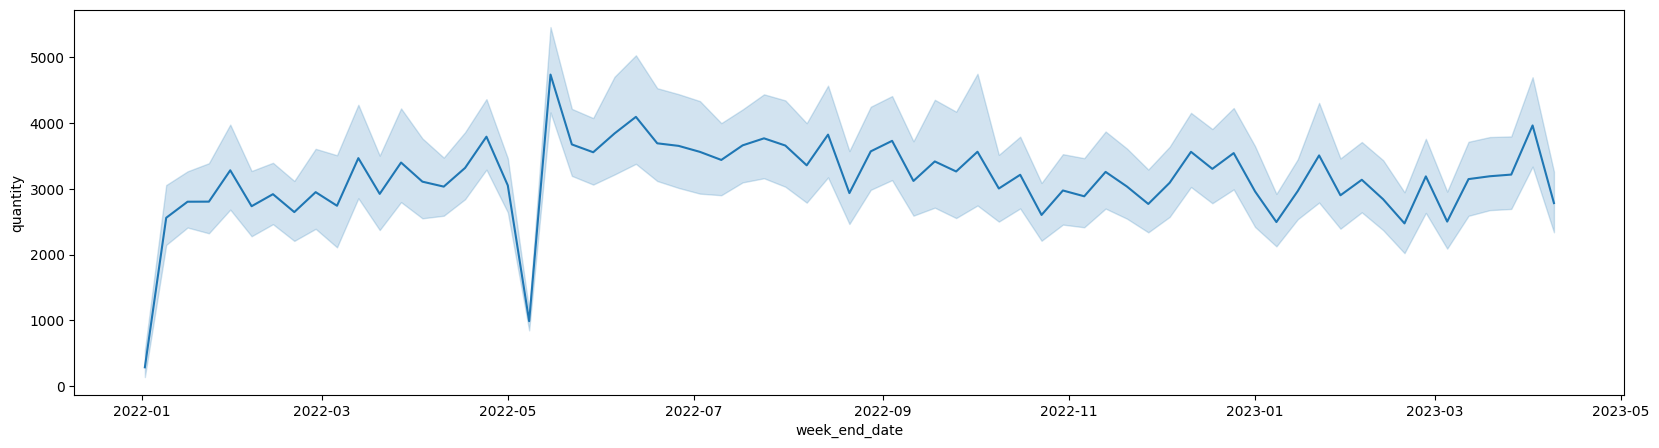

In [593]:
# product sold trend
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=df, x='week_end_date', y='quantity')
plt.show()

on the chart above, there is no seasonal pattern found on the data. the time series trend where the magnitude of the trend changes over time. In other words, the growth rate of the trend is not constant but varies. 

in other words the trend and seasonal are `multiplicative`.

### 4.3 Average Days to Sell 3000 Product

i'll start this analysis by assuming that the baseline for average sold item weekly is `3000`. with the magnitude of Paragon as a company, I believe it is a realistic number.

In [594]:
# create new df grouped by product
df_product = df.groupby(['product_item']).agg(
    total_quantity=('quantity', 'sum'),
    total_days_sold=('week_end_date', lambda x: (max(x) - min(x)).days +1)
)

# calculate days to sell 3000 products
df_product['days_to_sell_3000'] = 3000 / df_product['total_quantity'] * df_product['total_days_sold']
df_product = df_product.reset_index()
df_product.head()

,product_item,total_quantity,total_days_sold,days_to_sell_3000
0,00450b4fde94b528b4255b4f6f51599d,15691,435,83.168695
1,0065e8b533cd2c8273529312a6e8f219,29334,372,38.044590
2,0073377087c7ddace313ff829cd7b0b3,9645,463,144.012442
3,0098d23d332c193a07eabaf0f703d4e5,214632,456,6.373700
4,009e12e8fd2ef0b77047206e939fc6b9,39402,316,24.059692


In [595]:
# statistic descriptive
df_product.describe()

,total_quantity,total_days_sold,days_to_sell_3000
count,2.309000e+03,2309.000000,2309.000000
mean,1.420002e+05,334.777826,2068.383320
std,5.951554e+05,164.389700,8598.187795
min,2.000000e+00,1.000000,0.076292
25%,8.960000e+02,218.000000,15.864180
50%,1.040600e+04,449.000000,93.131548
75%,7.377700e+04,456.000000,593.370166
max,1.820638e+07,463.000000,189750.000000


In [596]:
df_product['days_to_sell_3000'].mode()

0    750.0
Name: days_to_sell_3000, dtype: float64

my first assumption is because the range of days to achieve `3,000 items sold` is too high, hence the average becomes high. we can see the minimum and the maximum of the `days_to_sell_3000` is high. at the same time the `mean` and the `median` is `quite far off`, which the distribution of the data might be skewed with a long tail.

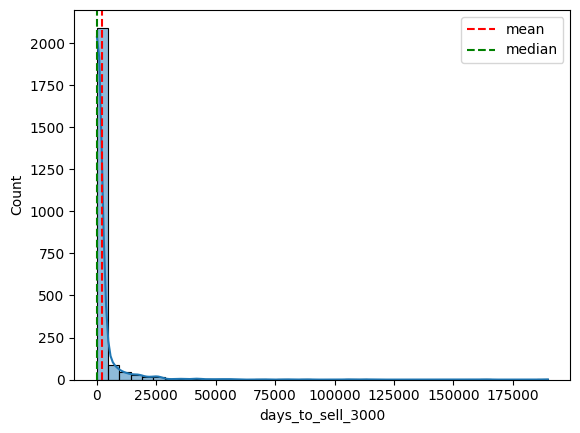

Average days to sell 3000 products: 2068.38


In [597]:
fig, ax= plt.subplots()

sns.histplot(df_product['days_to_sell_3000'], bins=40, kde=True, ax=ax)
ax.axvline(df_product['days_to_sell_3000'].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
ax.axvline(df_product['days_to_sell_3000'].median(), color = 'green', linestyle = 'dashed', label = 'median')
ax.legend()
plt.show()

print(f"Average days to sell 3000 products: {df_product['days_to_sell_3000'].mean():.2f}")

here my assumption is proved. we can see that the tail of the data distribution is skewed to the right with a long tail. thus, we have quite high average for `days_to_sell_300`.

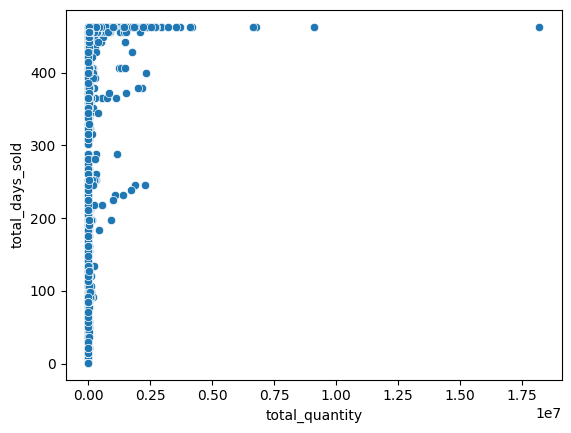

In [598]:
sns.scatterplot(data=df_product, x='total_quantity', y='total_days_sold')
plt.show()

just to recheck if total product is correlated with total days. but since each product vary, so there is no correlation between these two variables.

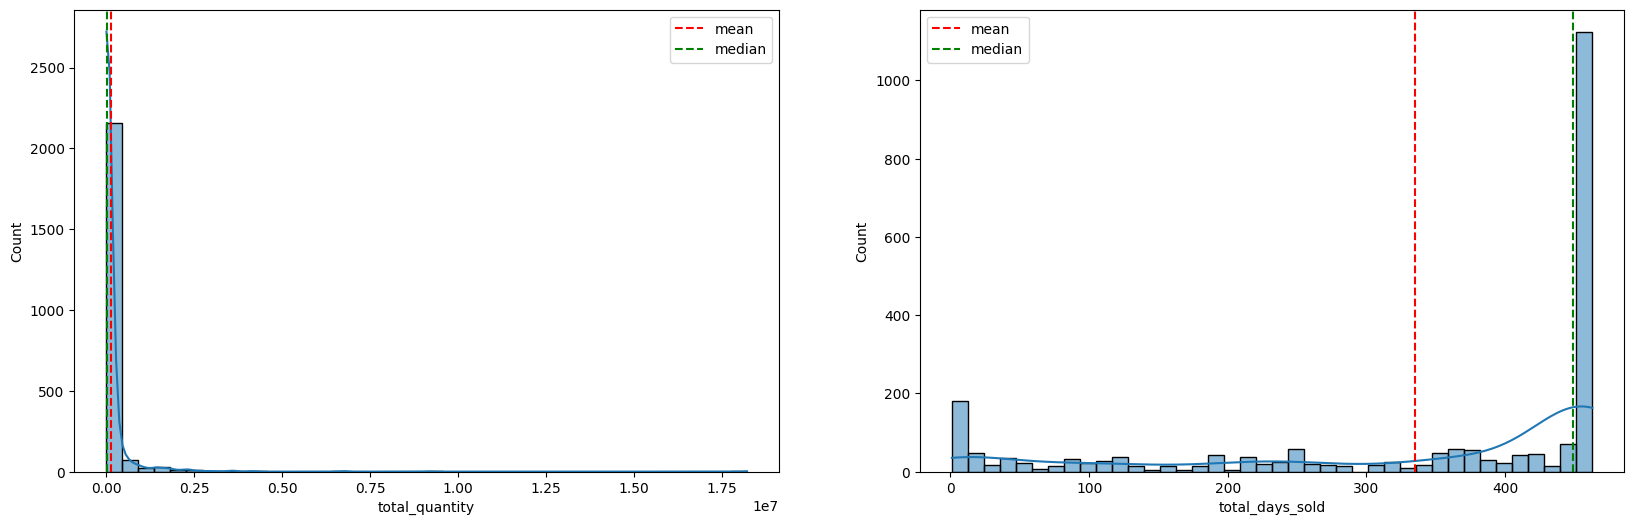

In [599]:
# comparison
# create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(20, 6))

sns.histplot(df_product['total_quantity'], bins=40, kde=True, ax=axs[0])
axs[0].axvline(df_product['total_quantity'].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
axs[0].axvline(df_product['total_quantity'].median(), color = 'green', linestyle = 'dashed', label = 'median')

sns.histplot(df_product['total_days_sold'], bins=40, kde=True, ax=axs[1])
axs[1].axvline(df_product['total_days_sold'].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
axs[1].axvline(df_product['total_days_sold'].median(), color = 'green', linestyle = 'dashed', label = 'median')

# add legends to both subplots
axs[0].legend()
axs[1].legend()

plt.show()

apparantly it goes the same with the `total_quantity` and the `total_days_sold` too. even the `total_quantity` is statistically is normally distributed because the `mean` and `median` is close to each other, but has `natural outliers` and the `performance of each products` are `vary` the data is has long tail in one end.

### 4.4 - Product Performance

In [600]:
# check the performance of each product
df_product['category'] = df_product['days_to_sell_3000'].apply(lambda x: 'in a day' if x <= 1 else 'in a week' if x > 1 and x <= 7 else 'in a month' if x > 7 and x <= 30 else '1-3 month' if x > 30 and x <= 90 else 'more than 3 month')
df_product.head()

,product_item,total_quantity,total_days_sold,days_to_sell_3000,category
0,00450b4fde94b528b4255b4f6f51599d,15691,435,83.168695,1-3 month
1,0065e8b533cd2c8273529312a6e8f219,29334,372,38.044590,1-3 month
2,0073377087c7ddace313ff829cd7b0b3,9645,463,144.012442,more than 3 month
3,0098d23d332c193a07eabaf0f703d4e5,214632,456,6.373700,in a week
4,009e12e8fd2ef0b77047206e939fc6b9,39402,316,24.059692,in a month


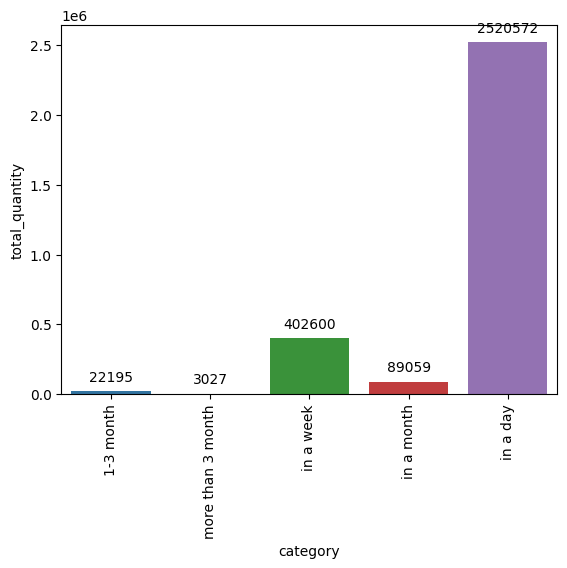

In [601]:
ax = sns.barplot(data=df_product, x='category', y='total_quantity', errorbar=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# show values on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.show()

as we can see, most of products are sold `3,000 pcs in a day` and very `few that sold more than in 3 months`. but since there is no further data regarding what kind of `products/category` are sold, i found it hard to analyze further or differentiate the time forecasting model for each category. 

# 5 - Data Preprocessing

In [602]:
product = df.copy()
product = product[['week_end_date', 'quantity']]
product = product[product['quantity'] != 0]
product = product.groupby('week_end_date')['quantity'].sum().reset_index()
product.set_index('week_end_date', inplace=True)
product.head()


,quantity
week_end_date,
2022-01-02,128808
2022-01-09,3839557
2022-01-16,4138934
2022-01-23,4149077
2022-01-30,4824273


the reason why i choose `week_end_date` here is because the report `only` can be generated at the end of time interval.

In [603]:
print(product.index.max())
print(product.index.min())

2023-04-09 00:00:00
2022-01-02 00:00:00


the data is started at `2nd of january 2022` from the accumulation of a week before, until the `mid-end of 2023`. 

# 6 - Model

### 6.1 - Checking Stationary

In [604]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

ADF Statistic: -7.950380
p-value: 0.000000
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592
Stationary


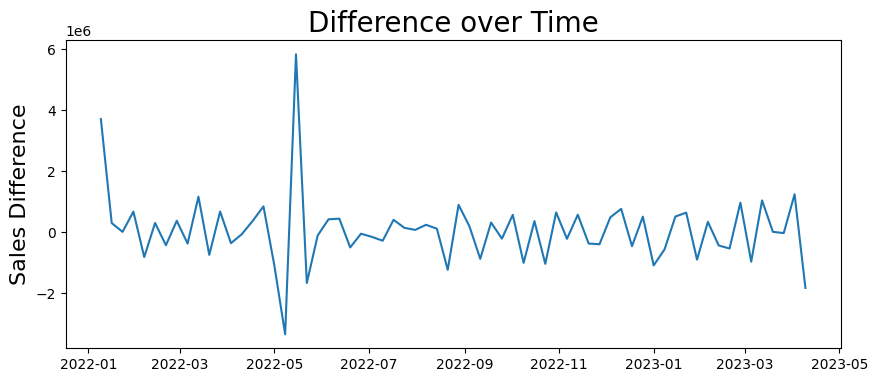

In [605]:
product_st = product.diff().dropna(0)

# checking stationarity using adfuller
check_stationarity(product_st)

# plotting the stationarity of the data
plt.figure(figsize=(10,4))
plt.plot(product_st)
plt.title('Difference over Time', fontsize=20)
plt.ylabel('Sales Difference', fontsize=16)
plt.show()

### 6.2 - Split Train & Test Set

In [606]:
#splitting train and test
train=product[:55] 
test=product[55:]

### 6.3 - Identifying Autocorrelation

The ACF and PACF plots are used in time series analysis to measure the autocorrelation of a time series, which refers to the correlation between a variable and its lagged version over time. The ACF plot shows the correlation between a time series and its lagged values, while the PACF plot shows the correlation between the time series and its lagged values while controlling for the values at other lags. Both plots can help determine the order of autoregressive (AR) and moving average (MA) processes, which are commonly used in time series analysis.

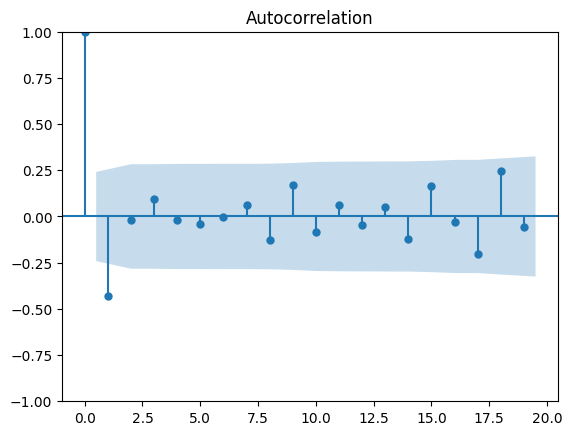

In [607]:
acf_plot = plot_acf(product.diff().dropna(0))

based on the ACF plot, the order for moving average that can be used are `0,1`.

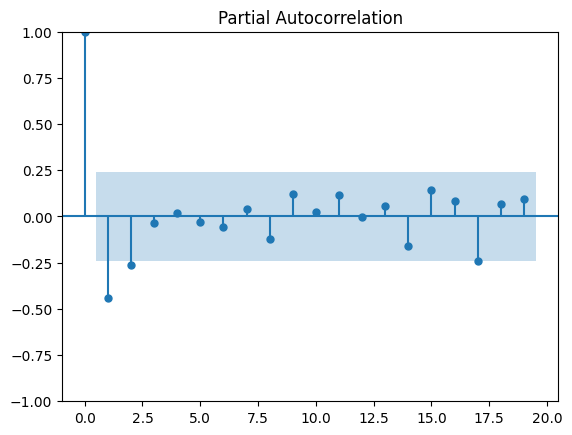

In [608]:
pacf_plot = plot_pacf(product.diff().dropna(0))

based on the PACF plot, the order for moving average that can be used are `0,1,2,and 17`.

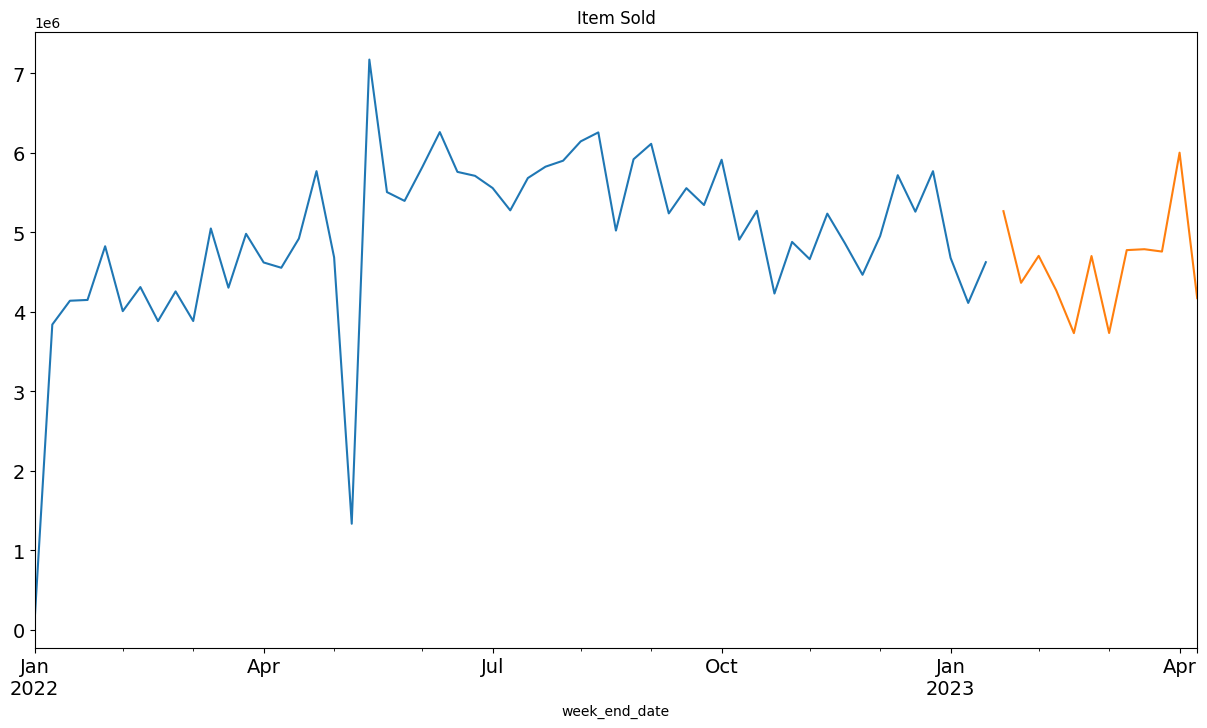

In [609]:
train.quantity.plot(figsize=(15,8), title= 'Item Sold', fontsize=14)
test.quantity.plot(figsize=(15,8), title= 'Item Sold', fontsize=14)

plt.show()

### 6.4 - Model: ARIMA

In [610]:
# Create and fit the SARIMAX model
model_arima = ARIMA(train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 4))
model_arima = model_arima.fit()

In [611]:
# Generate predictions for the test set
pred_arima = model_arima.forecast(steps=len(test)+4)

MAE : 447829.1791890009


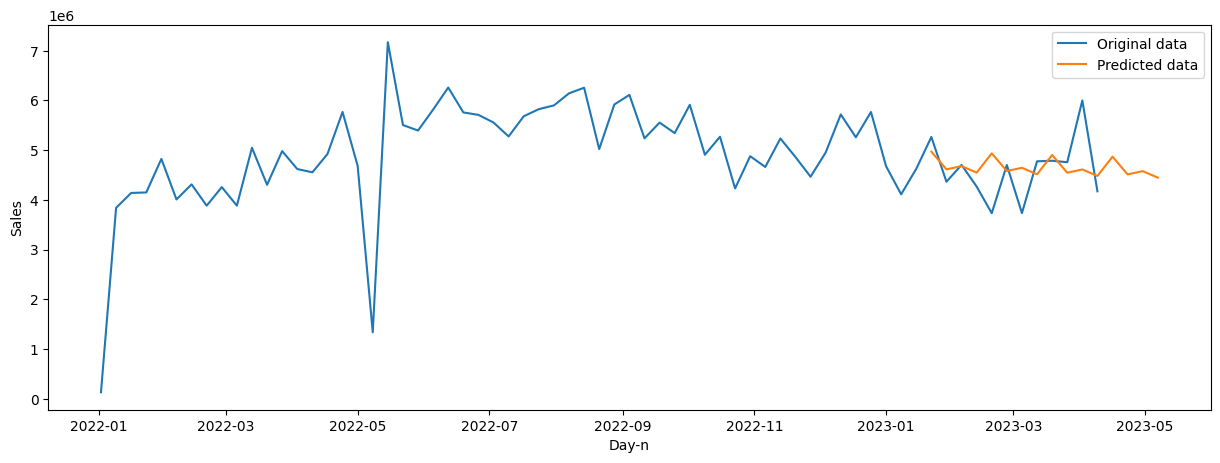

In [612]:
# Evaluate the model performance (MAE)
mae = mean_absolute_error(pred_arima[:12],test)
print(f'MAE : {mae}')

# Plot the original data_b1 and the predicted values
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(product.index, product['quantity'], label='Original data')
plt.plot(pred_arima.index, pred_arima, label='Predicted data')
plt.legend()
plt.xlabel('Day-n')
plt.ylabel('Sales')
plt.show()

- the average percentage difference between the actual and predicted values is around `9.5%` as it's shown in  `MAPE (Mean Absolute Percentage Error)` and the `MAE (Mean Absolute Error)` is `447,829`, which means that the average difference between the actual and predicted values is around `447,829` units.

- overall, the model's performance can be considered decent since the error is still within the range of product sold which is between `128,808 - 7,172,144`.

- the model also have tendency to predict `HIGHER` than `the actual value.`

In [613]:
df_product_new = pred_arima.tail(4)
df_product_new

2023-04-16    4.868672e+06
2023-04-23    4.512472e+06
2023-04-30    4.577794e+06
2023-05-07    4.446958e+06
Freq: W-SUN, Name: predicted_mean, dtype: float64

from the next 1 month the range of product sold `WEEKLY` will be between `4,026,852 - 4,922,512`.

### 6.5 - Model: Holt Winter

In [614]:
model_hw = ExponentialSmoothing(train,seasonal_periods=4, trend='multiplicative', seasonal='multiplicative').fit()

In [615]:
# Generate predictions for the test set
pred_hw = model_hw.forecast(steps=len(test)+4)

MAE : 485574.0319882782


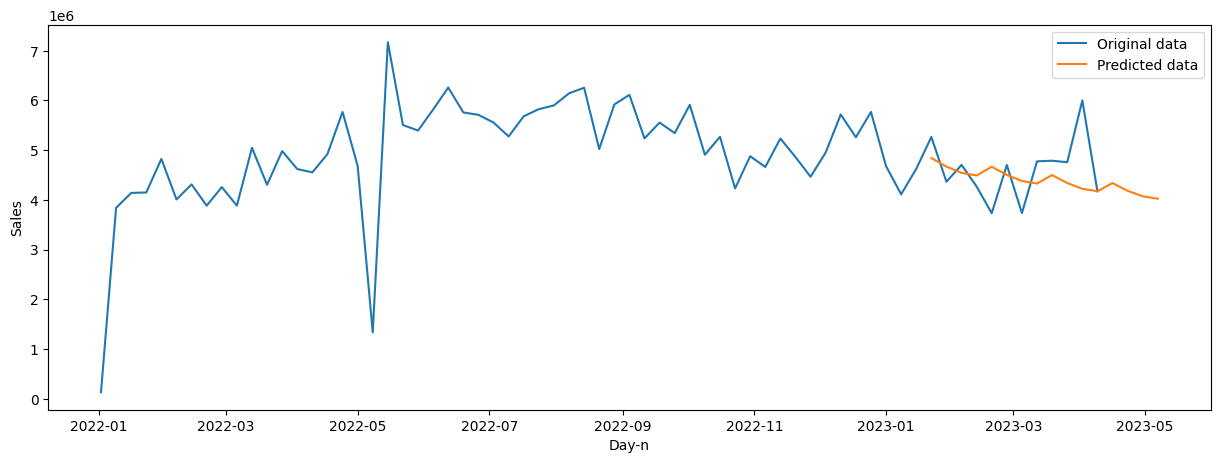

In [616]:
# Evaluate the model performance (MAE)
mae = mean_absolute_error(pred_hw[:12],test)
print(f'MAE : {mae}')

# Plot the original data_b1 and the predicted values
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(product.index, product['quantity'], label='Original data')
plt.plot(pred_hw.index, pred_hw, label='Predicted data')
plt.legend()
plt.xlabel('Day-n')
plt.ylabel('Sales')
plt.show()

- the average percentage difference between the actual and predicted values is around `11%` as it's shown in  `MAPE (Mean Absolute Percentage Error)` and the `MAE (Mean Absolute Error)` is `485.574`, which means that the average difference between the actual and predicted values is around `485.574` units.

- overall, the model's performance can be considered decent since the error is still within the range of product sold which is between `128,808 - 7,172,144`.

- the model also have tendency to predict `LOWER` than `the actual value`.

In [617]:
df_product_new = pred_hw.tail(4)
df_product_new

2023-04-16    4.337402e+06
2023-04-23    4.183303e+06
2023-04-30    4.070954e+06
2023-05-07    4.023329e+06
Freq: W-SUN, dtype: float64

from the next 1 month the range of product sold `WEEKLY` will be between `3,537,755 - 4,822,976`.

### 6.6 - Model: Linear Regression

In [618]:
sales = product.groupby('week_end_date')['quantity'].sum()
sales

week_end_date
2022-01-02     128808
2022-01-09    3839557
2022-01-16    4138934
2022-01-23    4149077
2022-01-30    4824273
               ...   
2023-03-12    4775638
2023-03-19    4787111
2023-03-26    4757590
2023-04-02    6001166
2023-04-09    4172070
Name: quantity, Length: 67, dtype: int64

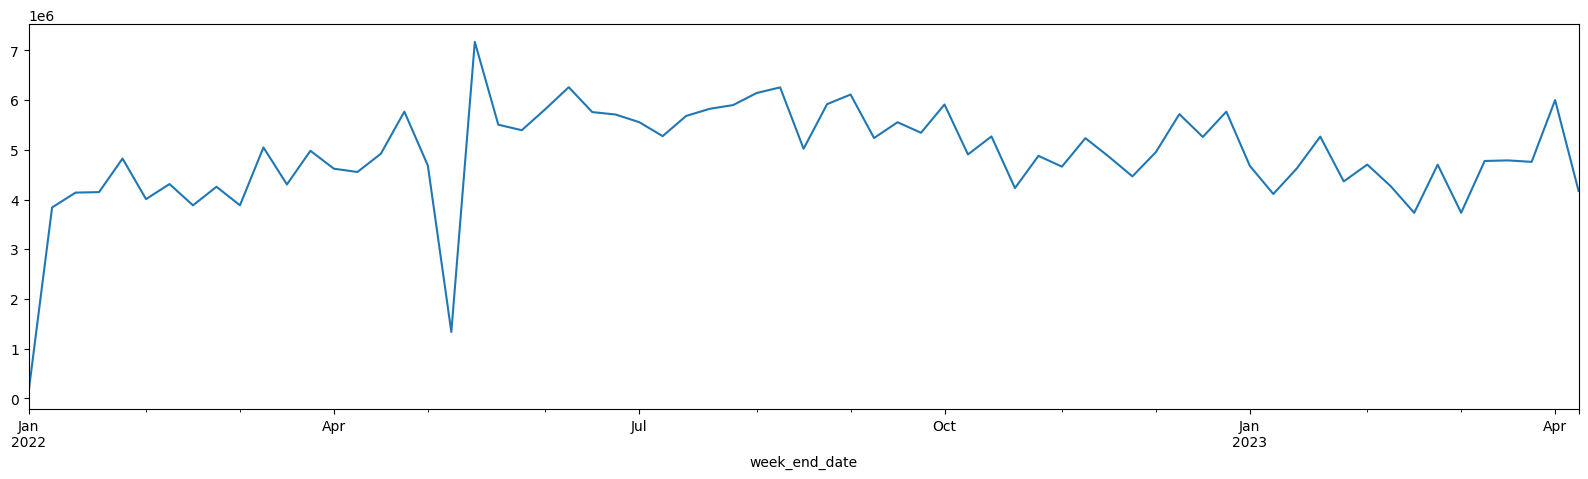

In [619]:
# trend visuazliation
sales.plot(figsize=(20,5))
plt.show()

#### 6.6.1 - Data Preprocessing

In [620]:
window = 4
x = []
y= []

for index in range(0, len(sales) - window):
    x.append(sales[index: window + index])
    y.append(sales[window + index])

x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

(63, 4)
(63,)


In [621]:
# Combines `X` and `y` into One DataFrame
X_y_df = pd.concat([pd.DataFrame(x, columns=['X0', 'X1', 'X2', 'X3']), pd.DataFrame(y, columns=['y'])], axis=1)
X_y_df

,X0,X1,X2,X3,y
0,128808,3839557,4138934,4149077,4824273
1,3839557,4138934,4149077,4824273,4008027
2,4138934,4149077,4824273,4008027,4311010
3,4149077,4824273,4008027,4311010,3882636
4,4824273,4008027,4311010,3882636,4256541
...,...,...,...,...,...
58,4267946,3731588,4701262,3732954,4775638
59,3731588,4701262,3732954,4775638,4787111
60,4701262,3732954,4775638,4787111,4757590
61,3732954,4775638,4787111,4757590,6001166


In [622]:
# Splitting Dataset
train_size = round(len(x)*0.8)

X_train = x[:train_size]
y_train = y[:train_size]

X_test = x[train_size:]
y_test = y[train_size:]

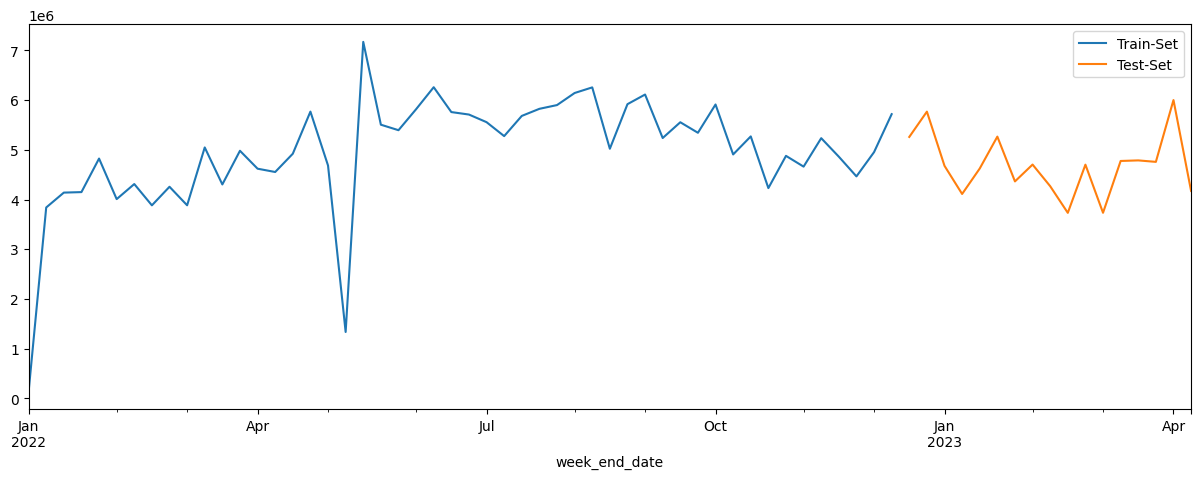

In [623]:
# Trend Visualization of train-set and test-set
sales[:train_size].plot.line(figsize=(15, 5))
sales[train_size:].plot.line(figsize=(15,5))
plt.legend(['Train-Set', 'Test-Set'])
plt.show()

In [624]:
# Feature Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [625]:
# Model Training
model_lr = LinearRegression(fit_intercept=True)
model_lr.fit(X_train_scaled,y_train)

y_pred_train = model_lr.predict(X_train_scaled)
y_pred_test = model_lr.predict(X_test_scaled)

print('Train MAE:',mean_absolute_error(y_train,y_pred_train))
print('Test MAE:',mean_absolute_error(y_test,y_pred_test))

Train MAE: 571644.9153519304
Test MAE: 529505.5730365796


In [626]:
# Combines All Prediction into One NumPy Array
y_pred_all = np.concatenate([np.array([0, 0, 0, 0]), y_pred_train, y_pred_test], axis=0)
y_pred_all

array([      0.        ,       0.        ,       0.        ,
             0.        , 3988815.9042535 , 4621943.16882857,
       4719668.69378952, 4813427.62757444, 4733272.83632077,
       4652820.85974639, 4621515.16063978, 4635424.92592175,
       4698762.43930358, 4870575.13437783, 4917854.10265463,
       4938955.66166021, 4949898.5064634 , 4931772.05532651,
       5075801.28202589, 5172062.62615427, 4807840.97870111,
       4362270.23075483, 5144438.25267214, 5589242.31547099,
       5366018.90363367, 5488112.62924205, 5609695.25272829,
       5543778.19884676, 5437775.84753692, 5372555.07578101,
       5323072.94913086, 5397337.2628447 , 5504129.99946208,
       5569540.3305848 , 5629179.3805054 , 5588401.34170994,
       5391660.34642602, 5434290.31021087, 5534382.01244569,
       5374255.9111859 , 5313393.62329013, 5345213.88695908,
       5362793.72968104, 5215180.80520399, 5066885.83930763,
       4923175.41144832, 4919359.57321652, 5010589.78207472,
       5076349.83550659,

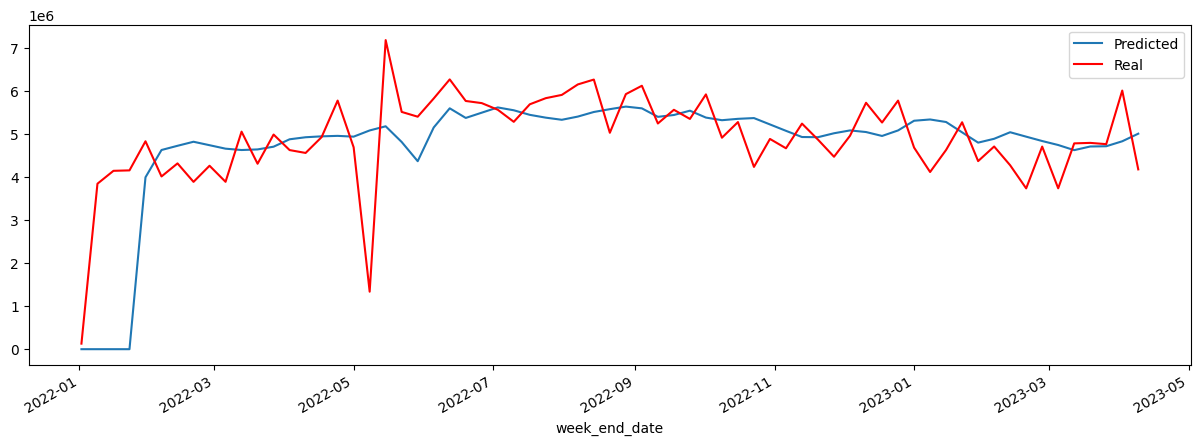

In [627]:
# Trend Visualization between Real Values and Predicted Values
plt.figure(figsize=(15, 5))
plt.plot(sales.index, y_pred_all,label='Predicted')
sales.plot(color='red',label='Real')
plt.legend()
plt.show()

- the average percentage difference between the actual and predicted values is around `12.2%` as it's shown in  `MAPE (Mean Absolute Percentage Error)` and the `MAE (Mean Absolute Error)` is `549,444`, which means that the average difference between the actual and predicted values is around `549,444` units.

- overall, the model's performance can be considered decent since the error is still within the range of product sold which is between `128,808 - 7,172,144`.

- the model also have tendency to predict `HIGHER` than `the actual value`.

#### 6.6.2 - Model Inference

In [628]:
# Function to Predict Sales in Next n-weeks
def forecasting(week):
  # :param `week` : how many week to predict

  sales_forecast = sales.copy()
  window = 4
  for i in range(week):
    X = np.array(sales_forecast[-window:].values).reshape(1, -1)
    X_scaled = scaler.transform(X)
    new_idx = pd.Timestamp(sales_forecast.index[-1]) + pd.Timedelta(days=7)
    sales_forecast[new_idx] = round(model_lr.predict(X_scaled)[0])

    print('i : ', i)
    print('X : ', X)
    print('X_scaled : ', X_scaled)
    print('new_idx : ', new_idx)
    print('sales_forecast[new_idx] : ', sales_forecast[new_idx])
    print('')

  return sales_forecast

i :  0
X :  [[4787111 4757590 6001166 4172070]]
X_scaled :  [[0.66137736 0.58640804 0.79942172 0.48611359]]
new_idx :  2023-04-16 00:00:00
sales_forecast[new_idx] :  5083166

i :  1
X :  [[4757590 6001166 4172070 5083166]]
X_scaled :  [[0.65718603 0.79942172 0.48611359 0.64217636]]
new_idx :  2023-04-23 00:00:00
sales_forecast[new_idx] :  5223332

i :  2
X :  [[6001166 4172070 5083166 5223332]]
X_scaled :  [[0.83374668 0.48611359 0.64217636 0.66618557]]
new_idx :  2023-04-30 00:00:00
sales_forecast[new_idx] :  5046745

i :  3
X :  [[4172070 5083166 5223332 5046745]]
X_scaled :  [[0.57405496 0.64217636 0.66618557 0.63593776]]
new_idx :  2023-05-07 00:00:00
sales_forecast[new_idx] :  5012831



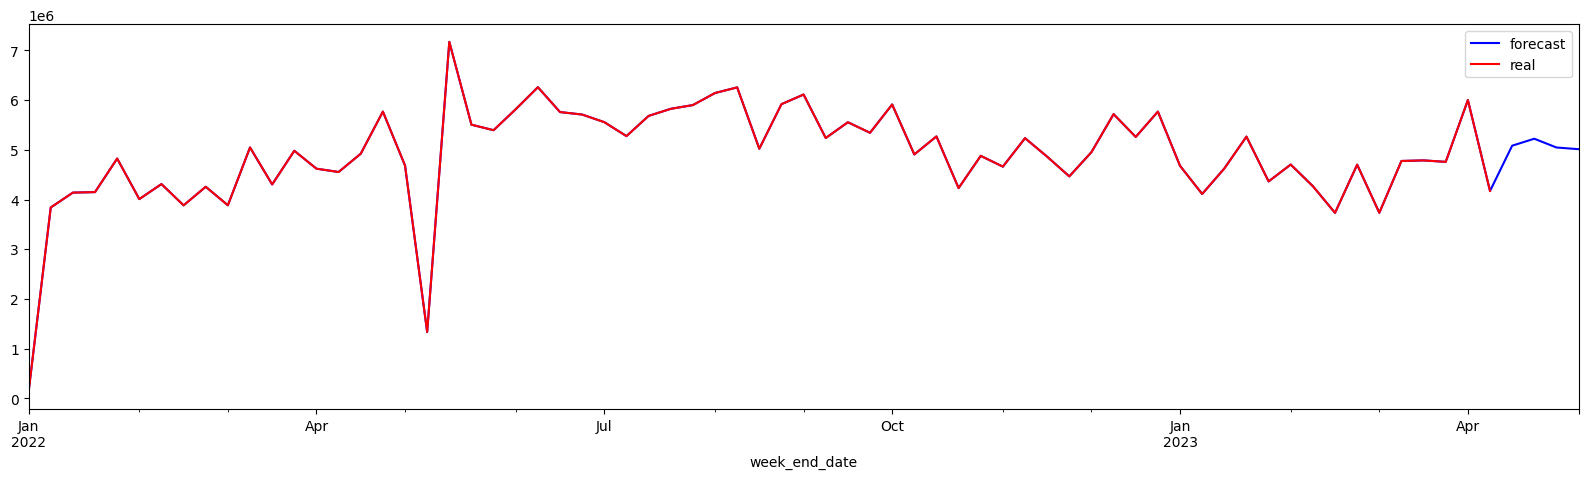

In [629]:
# Forecast for the Next 4 weeks

sales_forecast = forecasting(4)
sales_forecast.plot(color='blue',label='forecast',figsize=(20,5))
sales.plot(color='red',label='real')
plt.legend()

from the next 1 month the range of product sold `WEEKLY` will be between `4,310,904 - 5,728,090`.

# 7 - Model Saving

among three model we built, ARIMA appeared to perform the best. so, we'll save the model.

In [630]:
model_arima.save('model_arima.pkl')

# 8 - Conclusion

With approximately` 1,0000 rows` of data containing `2309 unique` products, this sales report presented only two empty values and some duplicated values, indicating a relatively small margin of human error. From the nature of the report which is the sales report, I assume the human error is relatively small compared to, for example, data that is gathered from the end user that sometimes has more inconsistency, empty values, or duplicated values. That's why i don't handle the outliers. The interval itself I get from the interval from the week_start_date and week_end_date, and it's only has one value. 

After plotting the data, no discernible pattern or trend emerged, suggesting a multiplicative relationship between trend and season as shown below:

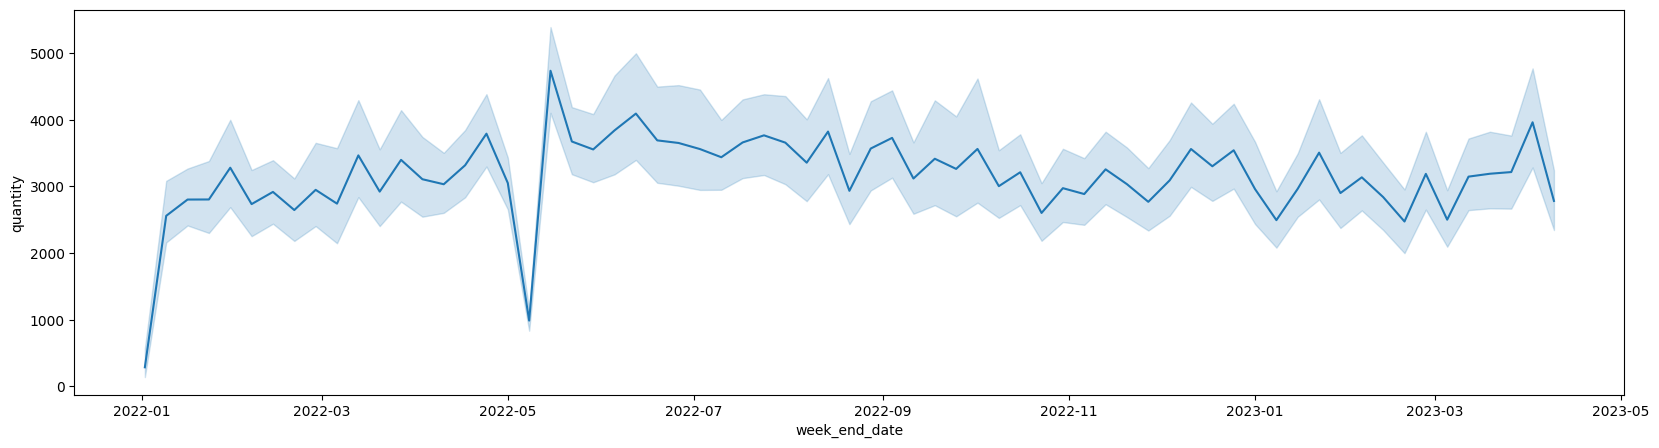

In [631]:
# product sold trend
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=df, x='week_end_date', y='quantity')
plt.show()

To assess individual product performance, the data was grouped by product and the average sold item quantity was used as a baseline, revealing a mean of `3,000`. The number of days required for a product to reach this benchmark was then calculated, and a visualization was produced indicating the number of products achieving this target within specific timeframes.

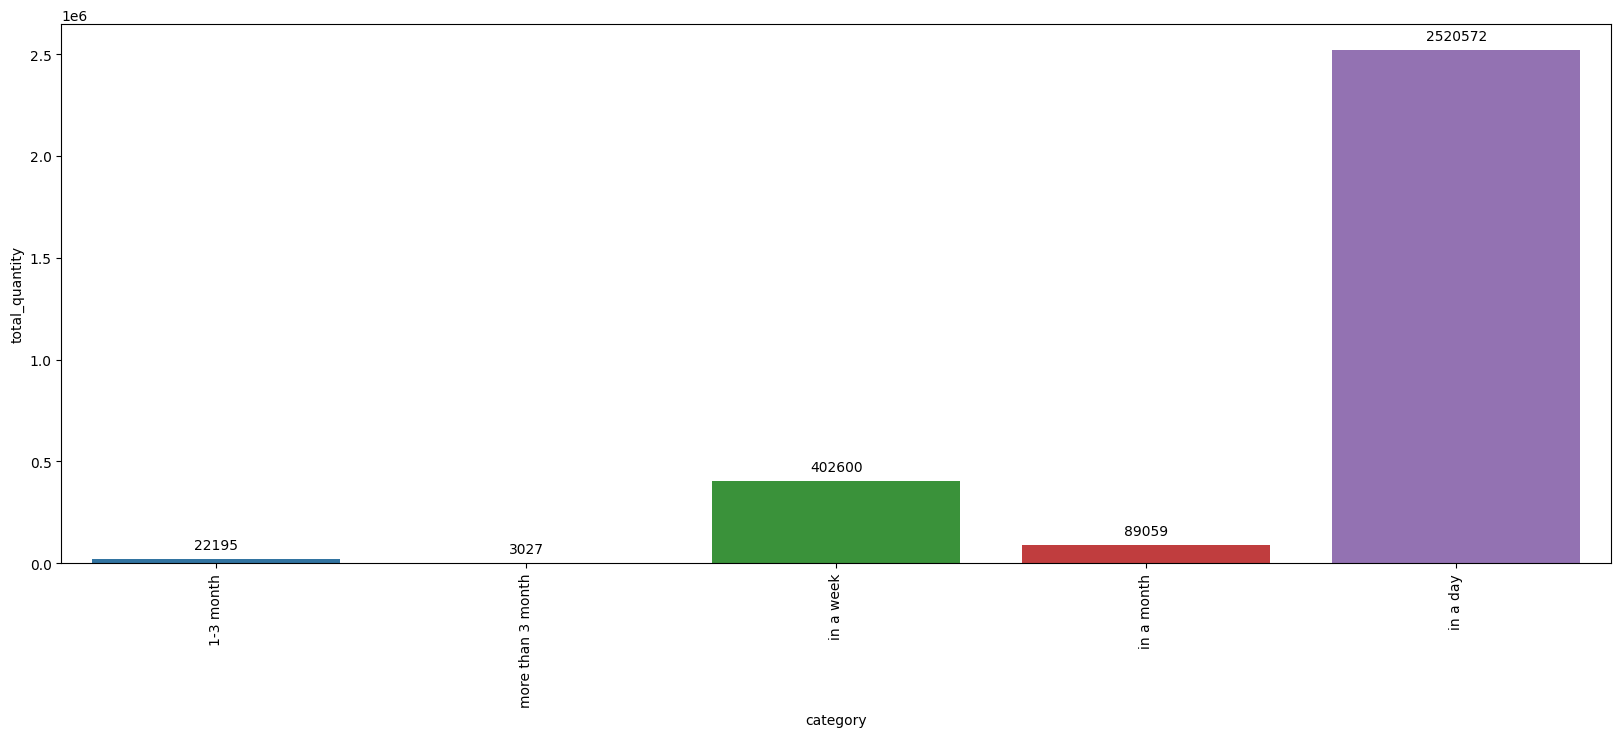

In [632]:
fig, ax = plt.subplots(figsize=(20,7))
ax = sns.barplot(data=df_product, x='category', y='total_quantity', errorbar=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# show values on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.show()

One limitation of the analysis was that the data was `grouped by overall sales, rather than individual products`, preventing deeper insights into which products were performing well or poorly. 

Despite this, the performance of three models - ARIMA, Holt Winter, and linear regression - were tested, with ARIMA producing the best results. While the model's average percentage difference between actual and predicted values was around `10%`, and the MAE was `447,829 units`, it still performed well, with errors within the range of product sold.

One notable observation was that the `ARIMA model tended to predict values that were higher` than the actual figures. The other two models showed similar tendencies, with Holt Winter predicting lower values than actual and linear regression predicting higher values.

Overall, the analysis was able to identify product performance, assess the accuracy of three different models, and select the best-performing one for future use. Despite the challenges of predicting trend and seasonality, the `ARIMA model's performance can be considered decent, given that it produced errors within the range of product sold`.

### Model Improvement

1. The data will be better if the `category of the product` is also `included` in the data. So that the the performance analysis on every product can be adressed better. And for me personally, this has better probability to `identify the patterns and seasonality`. So I could create separated models for each product and potentially `lower MEA` of my predictions.

2. Experiment using a different model altogether, such as a `seasonal ARIMA (SARIMA)` or a machine learning model like a `neural network` or a `random forest`.

3. Explore with different hyperparameters for the model.

4. Try `incorporating external factors` that may impact sales, such as holidays, marketing campaigns, or economic indicators. 